<a target="_blank" href="https://colab.research.google.com/github/MJ3128/CS-GY-6613-Assignments/blob/main/Take%20Home%20Exam%201/mj3128_Take_Home_Exam.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Problem 1: Take at Home  (45 points)

### Introduction
Typically when we train a Convolutional Neural Network as an end-to-end image classifier, we input an image to the network, which gets propagated through the network (feed forward).

We then obtain our posterior probabilities at the end of the network.

However, there is no “rule” that says we must allow the image to forward propagate through the entire network that includes the head. Instead, we can:

1) Stop propagation at a layer before the head of the network (such as an activation or pooling layer).

2) Extract the logits at this layer.

3) Treat the values as a feature vector.

Now these feature vectors can be utilized in other downstream tasks like classification. Our aim is to create a system where an input query image will be responded by a number of  images that have strong resemblance to the query image. This particular task is called **similarity search**. A naive way to perform this task, would be to compare images based on pixel values, patches, or some other high level feature taken from the image itself. You are askd to use the ResNet-50 architecture to produce features that can represent a concept aka a face with specific characteristics. 

### Part 1 Loading of Dataset in Colab (5 points)

Create a jupyter notebook (eg on Google Colab) and download the LFW dataset, from [here](http://vis-www.cs.umass.edu/lfw/).

You can manually download the dataset using the above link and then upload to colab or altelnatively you can issue in colab the commands shown below


In [ ]:
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
! tar -xvf /content/lfw.tgz

### Part 2 Using CNN for Feature Extraction (25 points)

Use ResNet50 to extract features vectors from raw images. You can use TF or Pytorch APIs to: 

* Obtain a ResNet-50  model pre-trained on a dataset such as ImageNet. 
* Perform necessary preprocessing on the images before feeding them into the network.
* Extract the features from the penultimate layer of the network (before the fully connected layer - the classification head).
* Store the features in a dictionary, where the key is the name of the image and the value is the feature vector.


## Importing Model

In [ ]:
# Libraries
import tensorflow as tf
from PIL import Image
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Get filenames and initilize empty dictionary
file_pattern = "/content/lfw/**/*.jpg"

class_dict = {}
file_paths = []

for file_name in glob.glob(file_pattern, recursive = True):
  class_name = os.path.basename(os.path.dirname(file_name))
  class_dict[class_name] = []
  file_paths.append(file_name)

file_paths.sort()

In [ ]:
# Obtaining The Model without the fully connected layer
resnet_model = tf.keras.applications.ResNet50(
    weights = "imagenet",
    include_top = False
)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freezing layers
for layer in resnet_model.layers:
  layer.trainable = False

## Data PreProcessing

In [ ]:
# Splits data because entire dataset is too much for google colab ram
dataset, _ = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/lfw",
    validation_split = 0.5,
    subset = "both",
    seed = 1,
    batch_size = 16,
    shuffle = False
)

Found 13233 files belonging to 5749 classes.
Using 6617 files for training.
Using 6616 files for validation.


In [ ]:
# Creating a resizing layer 
preprocessing_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(height = 224, width = 224),
    tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input)
])

In [ ]:
# Performing preprocessing on images
processed_data = dataset.map(lambda x, y: (preprocessing_layer(x), y))

In [ ]:
# Getting features
features = resnet_model.predict(processed_data, batch_size = 16)

414/414 [==============================] - 38s 67ms/step


In [ ]:
# Flattening and normalizing the features
num_images, height, width, depth = features.shape
flattened_features = features.reshape(num_images, height * width* depth)
normalized_features = []
for feature in flattened_features:
  normalized_features.append(feature / np.linalg.norm(feature))

In [ ]:
# Placing in dictionary
for index, feature in enumerate(features):
  filename = file_paths[index]
  class_name = os.path.basename(os.path.dirname(filename))
  class_dict[class_name].append(feature)

### Part 3 Retrieving most similar images (15 points)

Use a nearest neighbor algorithm such as [this](https://scikit-learn.org/stable/modules/neighbors.html) to obtain the 10 most similar images to 5 query images of your choice. Choose the results that best illustrate the effectiveness of your system. 


In [ ]:
from sklearn.neighbors import NearestNeighbors

# Create object that will run NN algorithm
nn = NearestNeighbors(
    n_neighbors = 2,
    metric = "euclidean"
).fit(flattened_features)

In [ ]:
# Get 5 random queries
import random

query_images = []
nearest_neighbors = []

for i in range(0, 5):
  index = random.randint(0, len(file_paths))
  query_images.append(index)
  query = tf.keras.utils.load_img(file_paths[index])
  query = tf.keras.utils.img_to_array(query)
  query = preprocessing_layer(query)
  query = np.expand_dims(query, axis = 0)
  query_features = resnet_model.predict(query)
  num_images, height, width, depth = query_features.shape
  query_features = query_features.reshape(num_images, height * width* depth)
  normalized_query_features = query_features / np.linalg.norm(query_features)
  _, indices = nn.kneighbors(query_features)
  nearest_neighbors.append(indices[0])


1/1 [==============================] - 0s 28ms/step


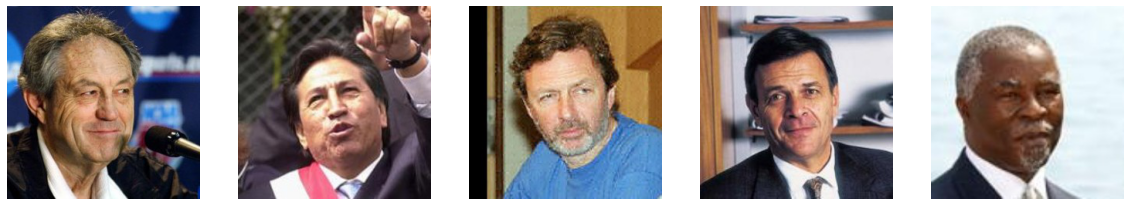

In [ ]:
# Query images subplots
plt.subplots(1, 5, figsize = (20, 20))
for i in range(0, 5):
  plt.subplot(1, 5, i + 1)
  plt.imshow(mpimg.imread(file_paths[query_images[i]]))
  plt.axis("off")

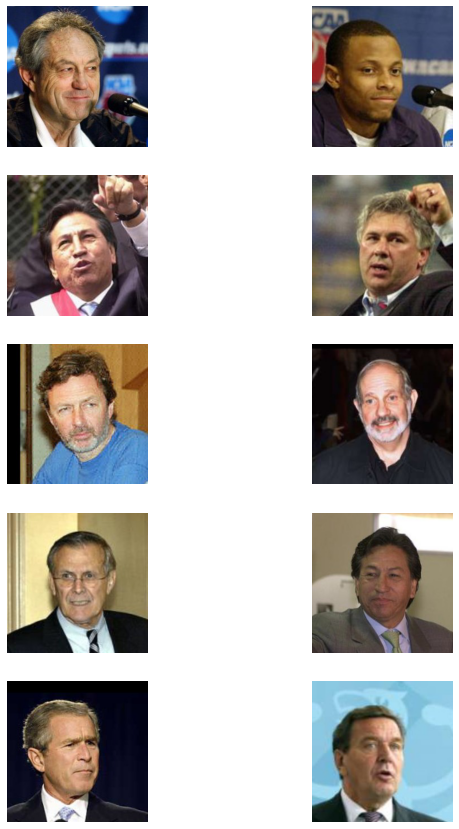

In [ ]:
plt.subplots(5, 2, figsize = (10, 15))
for i in range(0, 5):
  for j in range(0, 2):
    plt.subplot(5, 2, j + (i * 2) + 1)
    plt.imshow(mpimg.imread(file_paths[nearest_neighbors[i][j]]))
    plt.axis("off")

In [ ]:
print(query_images)
print(nearest_neighbors)

[5701, 10886, 6188, 10231, 11230]
[array([5701, 3324]), array([5029, 2973]), array([6188, 6180]), array([6296, 4046]), array([5837, 4647])]


## Final Result

The Code Above was ran a few times and below I will show the best results.

In [ ]:
query_1 = mpimg.imread(file_paths[6188])
query_2 = mpimg.imread(file_paths[10177])
query_3 = mpimg.imread(file_paths[6781])
query_4 = mpimg.imread(file_paths[6981])
query_5 = mpimg.imread(file_paths[6566])

similar_query1_1 = mpimg.imread(file_paths[6188])
similar_query1_2 = mpimg.imread(file_paths[6180])
similar_query2_1 = mpimg.imread(file_paths[855])
similar_query2_2 = mpimg.imread(file_paths[4240])
similar_query3_1 = mpimg.imread(file_paths[6267])
similar_query3_2 = mpimg.imread(file_paths[5623])
similar_query4_1 = mpimg.imread(file_paths[4024])
similar_query4_2 = mpimg.imread(file_paths[6062])
similar_query5_1 = mpimg.imread(file_paths[6566])
similar_query5_2 = mpimg.imread(file_paths[4373])


Text(0.5, 1.0, 'Similarity 2')

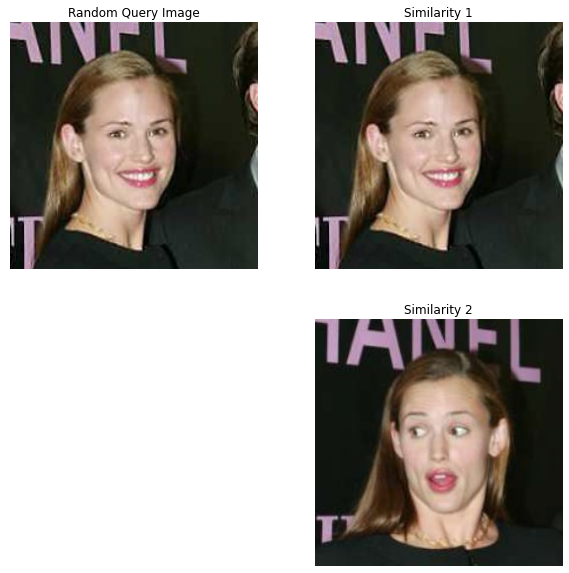

In [ ]:
plt.subplots(2, 2, figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(query_1)
plt.axis("off")
plt.title("Random Query Image")

plt.subplot(2, 2, 2)
plt.imshow(similar_query1_1)
plt.axis("off")
plt.title("Similarity 1")

plt.subplot(2, 2, 3)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(similar_query1_2)
plt.axis("off")
plt.title("Similarity 2")

Text(0.5, 1.0, 'Similarity 2')

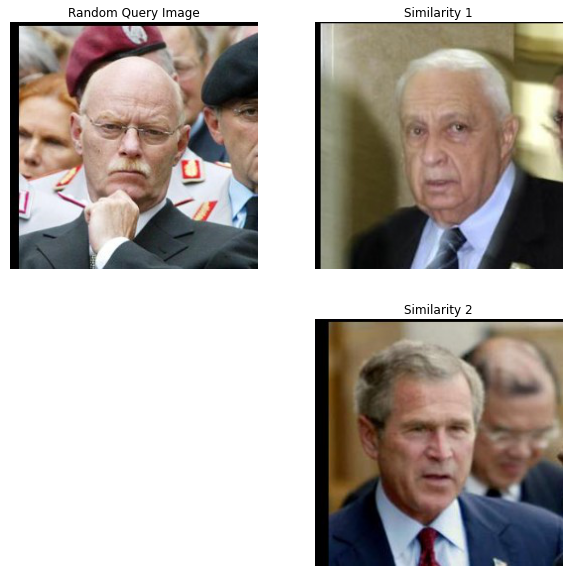

In [ ]:
plt.subplots(2, 2, figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(query_2)
plt.axis("off")
plt.title("Random Query Image")

plt.subplot(2, 2, 2)
plt.imshow(similar_query2_1)
plt.axis("off")
plt.title("Similarity 1")


plt.subplot(2, 2, 3)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(similar_query2_2)
plt.axis("off")
plt.title("Similarity 2")

Text(0.5, 1.0, 'Similarity 2')

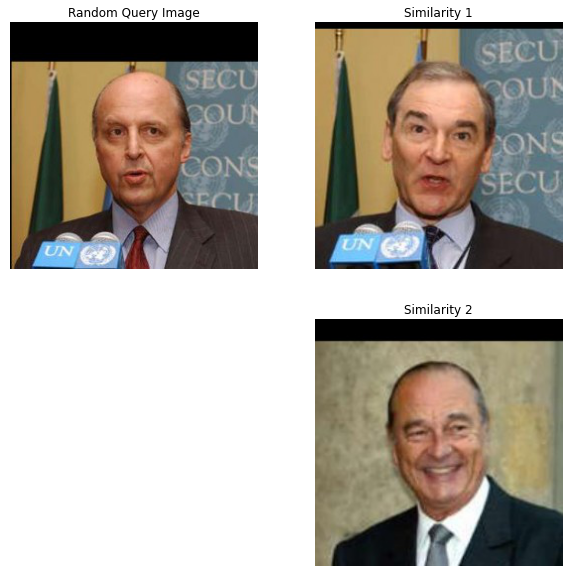

In [ ]:
plt.subplots(2, 2, figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(query_3)
plt.axis("off")
plt.title("Random Query Image")

plt.subplot(2, 2, 2)
plt.imshow(similar_query3_1)
plt.axis("off")
plt.title("Similarity 1")


plt.subplot(2, 2, 3)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(similar_query3_2)
plt.axis("off")
plt.title("Similarity 2")

Text(0.5, 1.0, 'Similarity 2')

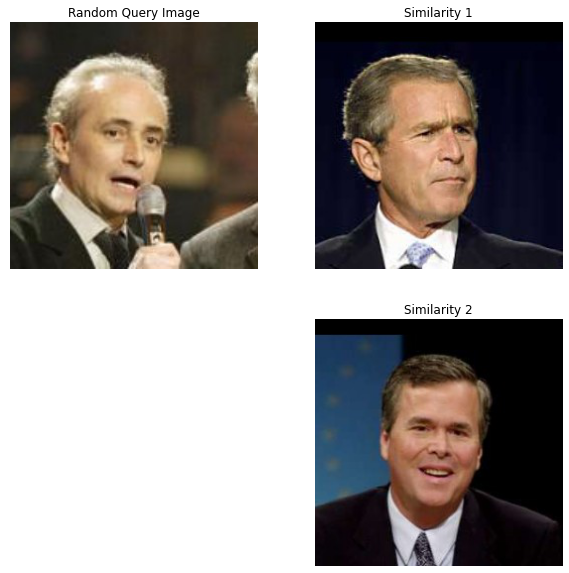

In [ ]:
plt.subplots(2, 2, figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(query_4)
plt.axis("off")
plt.title("Random Query Image")

plt.subplot(2, 2, 2)
plt.imshow(similar_query4_1)
plt.axis("off")
plt.title("Similarity 1")


plt.subplot(2, 2, 3)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(similar_query4_2)
plt.axis("off")
plt.title("Similarity 2")

Text(0.5, 1.0, 'Similarity 2')

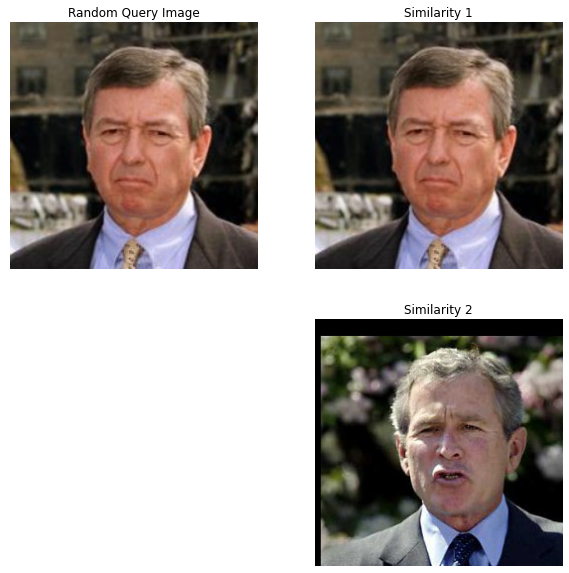

In [ ]:
plt.subplots(2, 2, figsize = (10, 10))

plt.subplot(2, 2, 1)
plt.imshow(query_5)
plt.axis("off")
plt.title("Random Query Image")

plt.subplot(2, 2, 2)
plt.imshow(similar_query5_1)
plt.axis("off")
plt.title("Similarity 1")


plt.subplot(2, 2, 3)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(similar_query5_2)
plt.axis("off")
plt.title("Similarity 2")